---
title: "NeRF Exploration: Two-View Reconstruction of Pollen Grains"
author: "Nils Fahrni, Etienne Roulet"
date: "2025-03-28"
format:
  html:
    toc: true
    code-fold: true
    code-line-numbers: true
    embed-resources: true
    self-contained-math: true
  ipynb: default
jupyter: python3
---

# Abstract

abstract desc

# 1 Introduction

Text here

**Key questions**

- Text
- Text
- Text


# 2 Environment check

In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())

CUDA available: True


# 3 NeRF exploration

## Implementation



[SYS] Using device: cuda
[DATA] Loaded sample #86 → images: torch.Size([1, 1024, 1024]),torch.Size([1, 1024, 1024]); points: torch.Size([4000, 3]); rotations (rad): [42.67660903930664, 57.744712829589844, 296.34222412109375]; voxels: torch.Size([128, 128, 128])
[DATA] Image dimensions: 1024x1024


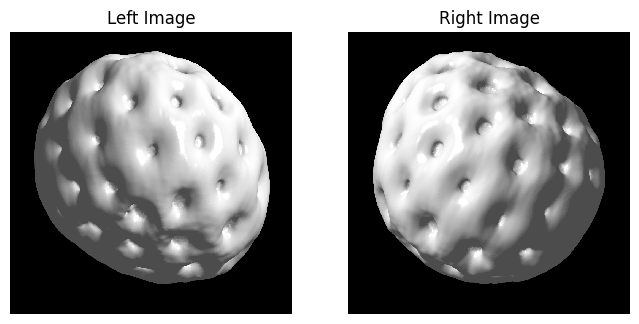

[TRAIN] Starting training ...


Training:   0%|          | 0/10000 [00:00<?, ?iter/s]c:\Users\super\Documents\GitHub\sequoia\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:1314: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  current = float(metrics)
Training:   2%|▏         | 210/10000 [00:03<02:35, 63.11iter/s]

Iter 200: total=0.0701, photo=0.0183, sil=0.0518, shape=0.0192, dens=0.0000, smooth=0.0000
[TRAIN] ==> New best model saved.


Training:   4%|▍         | 406/10000 [00:06<02:37, 61.06iter/s]

Iter 400: total=0.0601, photo=0.0073, sil=0.0527, shape=0.0169, dens=0.0000, smooth=0.0000
[TRAIN] ==> New best model saved.


Training:   6%|▌         | 608/10000 [00:10<02:26, 64.04iter/s]

Iter 600: total=0.0481, photo=0.0051, sil=0.0428, shape=0.0208, dens=0.0009, smooth=0.0000
[TRAIN] ==> New best model saved.


Training:   8%|▊         | 811/10000 [00:13<02:20, 65.19iter/s]

Iter 800: total=0.0394, photo=0.0042, sil=0.0352, shape=0.0185, dens=0.0000, smooth=0.0000
[TRAIN] ==> New best model saved.


Training:  10%|█         | 1007/10000 [00:16<02:16, 66.11iter/s]

Iter 1000: total=0.0374, photo=0.0041, sil=0.0331, shape=0.0235, dens=0.0009, smooth=0.0001
[TRAIN] ==> New best model saved.


Training:  12%|█▏        | 1210/10000 [00:19<02:15, 64.73iter/s]

Iter 1200: total=0.0472, photo=0.0045, sil=0.0424, shape=0.0298, dens=0.0017, smooth=0.0001


Training:  14%|█▍        | 1413/10000 [00:22<02:10, 65.59iter/s]

Iter 1400: total=0.0355, photo=0.0045, sil=0.0304, shape=0.0847, dens=0.0014, smooth=0.0024
[TRAIN] ==> New best model saved.


Training:  16%|█▌        | 1609/10000 [00:25<02:07, 65.88iter/s]

Iter 1600: total=0.0344, photo=0.0042, sil=0.0299, shape=0.0824, dens=0.0001, smooth=0.0025
[TRAIN] ==> New best model saved.


Training:  18%|█▊        | 1805/10000 [00:28<02:03, 66.41iter/s]

Iter 1800: total=0.0470, photo=0.0032, sil=0.0432, shape=0.0738, dens=0.0013, smooth=0.0027


Training:  20%|█▉        | 1994/10000 [00:31<02:02, 65.28iter/s]

Iter 2000: total=0.0517, photo=0.0038, sil=0.0473, shape=0.0818, dens=0.0010, smooth=0.0024
[DEBUG] Rendering images at iteration 2000 ...
[DEBUG RENDER] Saved front images at iter 2000 in debug_renders/
[DEBUG] Saved mask-vs-alpha comparison for front at iter 2000 in debug_renders/
[DEBUG RENDER] Saved side images at iter 2000 in debug_renders/


Training:  20%|██        | 2007/10000 [00:46<1:04:45,  2.06iter/s]

[DEBUG] Saved mask-vs-alpha comparison for side at iter 2000 in debug_renders/
[TRAIN] Saved checkpoint nerf_checkpoint_2000.pth



Training:  22%|██▏       | 2210/10000 [00:49<02:02, 63.55iter/s]  

Iter 2200: total=0.0322, photo=0.0030, sil=0.0285, shape=0.0747, dens=0.0016, smooth=0.0027
[TRAIN] ==> New best model saved.


Training:  24%|██▍       | 2406/10000 [00:52<01:56, 65.45iter/s]

Iter 2400: total=0.0412, photo=0.0030, sil=0.0372, shape=0.0804, dens=0.0037, smooth=0.0029


Training:  26%|██▌       | 2609/10000 [00:55<01:52, 65.58iter/s]

Iter 2600: total=0.0413, photo=0.0035, sil=0.0368, shape=0.0884, dens=0.0033, smooth=0.0028


Training:  28%|██▊       | 2805/10000 [00:58<01:49, 65.43iter/s]

Iter 2800: total=0.0440, photo=0.0034, sil=0.0399, shape=0.0875, dens=0.0015, smooth=0.0029


Training:  30%|███       | 3008/10000 [01:01<01:47, 65.05iter/s]

Iter 3000: total=0.0421, photo=0.0033, sil=0.0382, shape=0.0787, dens=0.0011, smooth=0.0033


Training:  32%|███▏      | 3211/10000 [01:05<01:42, 65.99iter/s]

Iter 3200: total=0.0364, photo=0.0039, sil=0.0316, shape=0.0750, dens=0.0027, smooth=0.0030


Training:  34%|███▍      | 3407/10000 [01:08<01:39, 66.19iter/s]

Iter 3400: total=0.0379, photo=0.0038, sil=0.0329, shape=0.0851, dens=0.0036, smooth=0.0034


Training:  36%|███▌      | 3610/10000 [01:11<01:36, 66.47iter/s]

Iter 3600: total=0.0359, photo=0.0032, sil=0.0319, shape=0.0801, dens=0.0020, smooth=0.0033


Training:  38%|███▊      | 3806/10000 [01:14<01:34, 65.63iter/s]

Iter 3800: total=0.0468, photo=0.0040, sil=0.0416, shape=0.0723, dens=0.0040, smooth=0.0035


Training:  40%|███▉      | 3995/10000 [01:17<01:31, 65.46iter/s]

Iter 4000: total=0.0362, photo=0.0031, sil=0.0322, shape=0.0768, dens=0.0026, smooth=0.0033
[DEBUG] Rendering images at iteration 4000 ...
[DEBUG RENDER] Saved front images at iter 4000 in debug_renders/
[DEBUG] Saved mask-vs-alpha comparison for front at iter 4000 in debug_renders/
[DEBUG RENDER] Saved side images at iter 4000 in debug_renders/


Training:  40%|████      | 4006/10000 [01:32<52:54,  1.89iter/s]  

[DEBUG] Saved mask-vs-alpha comparison for side at iter 4000 in debug_renders/
[TRAIN] Saved checkpoint nerf_checkpoint_4000.pth



Training:  42%|████▏     | 4207/10000 [01:36<01:40, 57.64iter/s]

Iter 4200: total=0.0481, photo=0.0031, sil=0.0444, shape=0.0831, dens=0.0011, smooth=0.0034


Training:  44%|████▍     | 4407/10000 [01:39<01:35, 58.32iter/s]

Iter 4400: total=0.0406, photo=0.0037, sil=0.0359, shape=0.0754, dens=0.0032, smooth=0.0034


Training:  46%|████▌     | 4604/10000 [01:43<01:40, 53.59iter/s]

Iter 4600: total=0.0363, photo=0.0035, sil=0.0319, shape=0.0865, dens=0.0026, smooth=0.0034


Training:  48%|████▊     | 4807/10000 [01:46<01:26, 59.70iter/s]

Iter 4800: total=0.0363, photo=0.0033, sil=0.0319, shape=0.0877, dens=0.0034, smooth=0.0039


Training:  50%|█████     | 5008/10000 [01:50<01:32, 53.95iter/s]

Iter 5000: total=0.0558, photo=0.0034, sil=0.0514, shape=0.0824, dens=0.0032, smooth=0.0037


Training:  52%|█████▏    | 5206/10000 [01:53<01:23, 57.32iter/s]

Iter 5200: total=0.0357, photo=0.0032, sil=0.0319, shape=0.0713, dens=0.0010, smooth=0.0039


Training:  54%|█████▍    | 5408/10000 [01:57<01:23, 55.32iter/s]

Iter 5400: total=0.0457, photo=0.0024, sil=0.0424, shape=0.0825, dens=0.0023, smooth=0.0033


Training:  56%|█████▌    | 5608/10000 [02:01<01:18, 55.63iter/s]

Iter 5600: total=0.0408, photo=0.0033, sil=0.0363, shape=0.0837, dens=0.0031, smooth=0.0040


Training:  58%|█████▊    | 5811/10000 [02:04<01:07, 62.12iter/s]

Iter 5800: total=0.0554, photo=0.0042, sil=0.0502, shape=0.0848, dens=0.0030, smooth=0.0036


Training:  60%|█████▉    | 5993/10000 [02:07<01:01, 64.71iter/s]

Iter 6000: total=0.0431, photo=0.0028, sil=0.0391, shape=0.0825, dens=0.0037, smooth=0.0037
[DEBUG] Rendering images at iteration 6000 ...
[DEBUG RENDER] Saved front images at iter 6000 in debug_renders/
[DEBUG] Saved mask-vs-alpha comparison for front at iter 6000 in debug_renders/
[DEBUG RENDER] Saved side images at iter 6000 in debug_renders/


Training:  60%|██████    | 6007/10000 [02:22<31:20,  2.12iter/s]

[DEBUG] Saved mask-vs-alpha comparison for side at iter 6000 in debug_renders/
[TRAIN] Saved checkpoint nerf_checkpoint_6000.pth



Training:  62%|██████▏   | 6210/10000 [02:26<00:58, 64.66iter/s]

Iter 6200: total=0.0339, photo=0.0035, sil=0.0297, shape=0.0858, dens=0.0008, smooth=0.0038


Training:  64%|██████▍   | 6406/10000 [02:29<00:57, 62.38iter/s]

Iter 6400: total=0.0428, photo=0.0034, sil=0.0383, shape=0.0816, dens=0.0032, smooth=0.0035


Training:  66%|██████▌   | 6609/10000 [02:32<00:52, 65.14iter/s]

Iter 6600: total=0.0476, photo=0.0028, sil=0.0438, shape=0.0873, dens=0.0026, smooth=0.0036


Training:  68%|██████▊   | 6812/10000 [02:35<00:48, 66.01iter/s]

Iter 6800: total=0.0386, photo=0.0032, sil=0.0345, shape=0.0832, dens=0.0019, smooth=0.0038


Training:  70%|███████   | 7008/10000 [02:38<00:46, 64.31iter/s]

Iter 7000: total=0.0445, photo=0.0029, sil=0.0408, shape=0.0824, dens=0.0014, smooth=0.0040


Training:  72%|███████▏  | 7211/10000 [02:41<00:43, 64.10iter/s]

Iter 7200: total=0.0434, photo=0.0039, sil=0.0383, shape=0.0890, dens=0.0040, smooth=0.0034


Training:  74%|███████▍  | 7407/10000 [02:44<00:40, 64.42iter/s]

Iter 7400: total=0.0439, photo=0.0033, sil=0.0398, shape=0.0803, dens=0.0014, smooth=0.0039


Training:  76%|███████▌  | 7610/10000 [02:47<00:36, 65.60iter/s]

Iter 7600: total=0.0400, photo=0.0041, sil=0.0344, shape=0.0740, dens=0.0050, smooth=0.0037


Training:  78%|███████▊  | 7806/10000 [02:50<00:33, 64.55iter/s]

Iter 7800: total=0.0474, photo=0.0037, sil=0.0425, shape=0.0844, dens=0.0036, smooth=0.0038


Training:  80%|███████▉  | 7995/10000 [02:53<00:30, 66.43iter/s]

Iter 8000: total=0.0429, photo=0.0033, sil=0.0383, shape=0.0735, dens=0.0039, smooth=0.0039
[DEBUG] Rendering images at iteration 8000 ...
[DEBUG RENDER] Saved front images at iter 8000 in debug_renders/
[DEBUG] Saved mask-vs-alpha comparison for front at iter 8000 in debug_renders/
[DEBUG RENDER] Saved side images at iter 8000 in debug_renders/


Training:  80%|████████  | 8009/10000 [03:08<15:16,  2.17iter/s]

[DEBUG] Saved mask-vs-alpha comparison for side at iter 8000 in debug_renders/
[TRAIN] Saved checkpoint nerf_checkpoint_8000.pth



Training:  82%|████████▏ | 8205/10000 [03:12<00:27, 64.14iter/s]

Iter 8200: total=0.0357, photo=0.0030, sil=0.0320, shape=0.0809, dens=0.0014, smooth=0.0039


Training:  84%|████████▍ | 8408/10000 [03:15<00:24, 64.42iter/s]

Iter 8400: total=0.0430, photo=0.0034, sil=0.0391, shape=0.0752, dens=0.0007, smooth=0.0035


Training:  86%|████████▌ | 8604/10000 [03:18<00:22, 61.44iter/s]

Iter 8600: total=0.0308, photo=0.0030, sil=0.0267, shape=0.0805, dens=0.0027, smooth=0.0040
[TRAIN] ==> New best model saved.


Training:  88%|████████▊ | 8807/10000 [03:21<00:18, 63.90iter/s]

Iter 8800: total=0.0416, photo=0.0045, sil=0.0356, shape=0.0926, dens=0.0054, smooth=0.0035


Training:  90%|█████████ | 9010/10000 [03:24<00:15, 63.24iter/s]

Iter 9000: total=0.0449, photo=0.0037, sil=0.0402, shape=0.0817, dens=0.0029, smooth=0.0039


Training:  92%|█████████▏| 9206/10000 [03:27<00:12, 63.82iter/s]

Iter 9200: total=0.0351, photo=0.0036, sil=0.0309, shape=0.0773, dens=0.0010, smooth=0.0039


Training:  94%|█████████▍| 9409/10000 [03:30<00:08, 65.88iter/s]

Iter 9400: total=0.0447, photo=0.0030, sil=0.0409, shape=0.0814, dens=0.0011, smooth=0.0041


Training:  96%|█████████▌| 9605/10000 [03:33<00:06, 65.31iter/s]

Iter 9600: total=0.0305, photo=0.0024, sil=0.0274, shape=0.0791, dens=0.0007, smooth=0.0038
[TRAIN] ==> New best model saved.


Training:  98%|█████████▊| 9808/10000 [03:37<00:02, 66.08iter/s]

Iter 9800: total=0.0384, photo=0.0030, sil=0.0347, shape=0.0852, dens=0.0009, smooth=0.0040


Training: 100%|█████████▉| 9997/10000 [03:39<00:00, 65.87iter/s]

Iter 10000: total=0.0375, photo=0.0032, sil=0.0334, shape=0.0804, dens=0.0021, smooth=0.0035
[DEBUG] Rendering images at iteration 10000 ...
[DEBUG RENDER] Saved front images at iter 10000 in debug_renders/
[DEBUG] Saved mask-vs-alpha comparison for front at iter 10000 in debug_renders/


Training: 100%|█████████▉| 9997/10000 [03:50<00:00, 65.87iter/s]

[DEBUG RENDER] Saved side images at iter 10000 in debug_renders/


Training: 100%|██████████| 10000/10000 [03:54<00:00, 42.57iter/s]

[DEBUG] Saved mask-vs-alpha comparison for side at iter 10000 in debug_renders/
[TRAIN] Saved checkpoint nerf_checkpoint_10000.pth

[TRAIN] Done.

[EXTRACT 3D] Running marching cubes...


  Sigma volume stats: min=0.0000, max=5.6614, mean=0.4340, std=0.7103
  Using iso-level=0.8603
  --> Saved mesh to nerf_reconstruction.stl

[RESULT] Chamfer Dist (Pred vs. GT point‐cloud): 1725.792575

Done.


In [ ]:
import os
import sys
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.spatial import cKDTree
from skimage.measure import marching_cubes
import trimesh

# If you have the data package
sys.path.append("..")
try:
    from data.pollen_dataset import PollenDataset, get_train_test_split
except ImportError:
    # Fallback if not available
    PollenDataset = None
    get_train_test_split = None

torch.backends.cudnn.benchmark = True

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


################################################################################
# 1. Positional Encoding (Reduced Frequencies)
################################################################################
def positional_encoding(x, L=4):
    """
    Encode coordinates x with sine/cosine functions at increasing frequencies.
    We use L=4 here (fewer than the classic L=10) to reduce high-frequency overfitting.
    """
    out = [x]
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            out.append(fn((2.0**i) * np.pi * x))
    return torch.cat(out, dim=-1)


################################################################################
# 2. NeRF Model with Reduced Positional Encoding
################################################################################
class NeRF(nn.Module):
    def __init__(self, D=6, W=128, L=4):
        """
        Args:
            D: Number of hidden layers
            W: Number of hidden units per layer
            L: Positional encoding frequency levels
        """
        super(NeRF, self).__init__()
        self.L = L
        in_channels = 3 * (2 * L + 1)  # 3 coords * (2L + 1)

        layers = []
        layers.append(nn.Linear(in_channels, W))
        for _ in range(D - 1):
            layers.append(nn.Linear(W, W))

        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(W, 4)

        # Initialize sigma bias to something non-zero
        with torch.no_grad():
            self.output_layer.bias[3] = 0.1

    def forward(self, x):
        """
        Forward pass: x is (N, 3), output is (N, 4) => [R, G, B, sigma].
        """
        x_enc = positional_encoding(x, self.L)
        h = x_enc
        for layer in self.layers:
            h = torch.relu(layer(h))
        return self.output_layer(h)


################################################################################
# 3. Render Rays (RGB + Alpha)
################################################################################
def render_rays(
    model, rays_o, rays_d, near=0.5, far=1.5, N_samples=128, sigma_scale=1.0
):
    """
    Volumetric rendering for a batch of rays:
      - Sample points along each ray
      - Query MLP for color (rgb) and density (sigma)
      - Composite color and alpha
    """
    device = rays_o.device
    z_vals = torch.linspace(near, far, N_samples, device=device)

    pts = (
        rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]
    )  # (B, N_samples, 3)
    pts_flat = pts.reshape(-1, 3)

    raw = model(pts_flat).reshape(pts.shape[0], N_samples, 4)
    rgb = torch.sigmoid(raw[..., :3])
    sigma = torch.relu(raw[..., 3]) * sigma_scale
    sigma = torch.clamp(sigma, max=10.0)   # prevents exploding densities


    deltas = z_vals[1:] - z_vals[:-1]
    deltas = torch.cat([deltas, torch.tensor([1e10], device=device)])
    deltas = deltas[None, :].expand(sigma.shape)

    alpha = 1.0 - torch.exp(-sigma * deltas)
    T = torch.cumprod(
        torch.cat(
            [torch.ones((sigma.shape[0], 1), device=device), 1.0 - alpha + 1e-10],
            dim=-1,
        ),
        dim=-1,
    )[:, :-1]
    weights = alpha * T

    rgb_map = torch.sum(weights[..., None] * rgb, dim=1)
    alpha_map = torch.sum(weights, dim=1)
    return rgb_map, alpha_map


################################################################################
# 4. Losses: Silhouette, Spherical Prior, etc.
################################################################################
def silhouette_loss(alpha_map, mask):
    return torch.mean((alpha_map - mask) ** 2)


def spherical_prior_loss(
    model, num_samples=2000, bound=1.0, desired_radius=0.6, sigma_scale=2.0, device=None
):
    if device is None:
        device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound

    raw = model(coords)
    sigma = torch.relu(raw[..., 3]) * sigma_scale
    dists = torch.norm(coords, dim=1)
    # Encourage high sigma near the desired radius
    loss = torch.mean(sigma * (dists - desired_radius) ** 2)
    return loss


def foreground_density_loss(alpha_map, mask, target_density=1.0):
    eps = 1e-6
    D = -torch.log(1.0 - alpha_map + eps)
    fg_mask = mask > 0.5
    if torch.sum(fg_mask) > 0:
        return torch.mean(torch.clamp(target_density - D[fg_mask], min=0.0))
    else:
        return torch.tensor(0.0, device=alpha_map.device)


def smoothness_prior_loss(
    model, num_samples=2000, bound=1.0, offset=0.01, sigma_scale=2.0, device=None
):
    if device is None:
        device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound

    raw_center = model(coords)
    sigma_center = torch.relu(raw_center[..., 3]) * sigma_scale

    offsets = torch.tensor(
        [
            [offset, 0, 0],
            [-offset, 0, 0],
            [0, offset, 0],
            [0, -offset, 0],
            [0, 0, offset],
            [0, 0, -offset],
        ],
        device=device,
    ).float()

    total_diff = 0.0
    for off in offsets:
        neighbor_coords = coords + off
        raw_neighbor = model(neighbor_coords)
        sigma_neighbor = torch.relu(raw_neighbor[..., 3]) * sigma_scale
        total_diff += torch.mean((sigma_center - sigma_neighbor) ** 2)

    return total_diff / offsets.shape[0]


################################################################################
# 5. Ray Generation (Two Orthogonal Views)
################################################################################
import torch
from trimesh.transformations import euler_matrix


def get_rays(H, W, focal=300.0):
    """
    Returns canonical (unrotated) front‐and‐side rays:
      rays_o_front, rays_d_front, rays_o_side, rays_d_side
      all as (H*W, 3) tensors.
    """
    i, j = torch.meshgrid(
        torch.linspace(0, W - 1, W),
        torch.linspace(0, H - 1, H),
        indexing="xy",
    )
    # front
    dirs_f = torch.stack(
        [(i - W / 2.0) / focal, -(j - H / 2.0) / focal, -torch.ones_like(i)],
        dim=-1,
    )
    rays_d_f = dirs_f / torch.norm(dirs_f, dim=-1, keepdim=True)
    rays_o_f = torch.zeros_like(rays_d_f)

    # side
    dirs_s = torch.stack(
        [torch.ones_like(i), -(j - H / 2.0) / focal, -(i - W / 2.0) / focal],
        dim=-1,
    )
    rays_d_s = dirs_s / torch.norm(dirs_s, dim=-1, keepdim=True)
    rays_o_s = torch.zeros_like(rays_d_s)
    rays_o_s[..., 0] = -1.5

    return (
        rays_o_f.reshape(-1, 3),
        rays_d_f.reshape(-1, 3),
        rays_o_s.reshape(-1, 3),
        rays_d_s.reshape(-1, 3),
    )


def rotate_rays(rays_o, rays_d, euler_angles):
    """
    Apply the sample's rotation (in radians) to both origins and directions.
    euler_angles: tensor([rx, ry, rz]) in radians, in 'sxyz' convention.
    """
    # build 4×4 rotation matrix, then extract the 3×3 upper‐left block
    R4 = euler_matrix(
        float(euler_angles[0]),
        float(euler_angles[1]),
        float(euler_angles[2]),
        "sxyz",
    )
    R = torch.from_numpy(R4[:3, :3]).to(rays_o.device).float()

    # rotate origins & directions
    ro = (R @ rays_o.T).T
    rd = (R @ rays_d.T).T
    return ro, rd


################################################################################
# 6. Weighted Ray Sampling (Edges + Foreground)
################################################################################
def sample_rays_weighted(rays_o, rays_d, rgb, mask, original_shape, batch_size=1024):
    """
    Sample rays with higher probability at silhouette edges and foreground.
    """
    H, W = original_shape
    total_pixels = mask.shape[0]
    pixels_per_view = H * W

    if total_pixels == 2 * pixels_per_view:
        # Two views
        weights_list = []
        for view_idx in range(2):
            start_idx = view_idx * pixels_per_view
            end_idx = start_idx + pixels_per_view
            view_mask = mask[start_idx:end_idx]
            mask_2d = view_mask.reshape(H, W)

            kernel = (
                torch.tensor(
                    [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], device=mask.device
                ).float()
                / 8
            )
            kernel = kernel.reshape(1, 1, 3, 3)

            edges = torch.abs(
                torch.nn.functional.conv2d(
                    mask_2d.reshape(1, 1, H, W), kernel, padding=1
                )
            ).reshape(H, W)
            edge_weights = edges.reshape(-1) + 0.1
            fg_weights = (view_mask > 0.5).float() * 2.0
            weights = edge_weights + fg_weights
            weights_list.append(weights)
        weights = torch.cat(weights_list)
    else:
        # Single view fallback
        mask_2d = mask.reshape(H, W)
        kernel = (
            torch.tensor(
                [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], device=mask.device
            ).float()
            / 8
        )
        kernel = kernel.reshape(1, 1, 3, 3)
        edges = torch.abs(
            torch.nn.functional.conv2d(mask_2d.reshape(1, 1, H, W), kernel, padding=1)
        ).reshape(H, W)
        edge_weights = edges.reshape(-1) + 0.1
        fg_weights = (mask > 0.5).float() * 2.0
        weights = edge_weights + fg_weights

    p = weights / weights.sum()
    idx = torch.multinomial(p, batch_size, replacement=True)

    return rays_o[idx], rays_d[idx], rgb[idx], mask[idx]


################################################################################
# 7. Debug Rendering (with Extra Mask Comparison)
################################################################################
@torch.no_grad()
def debug_render(
    model,
    rays_o,
    rays_d,
    H,
    W,
    near=0.3,
    far=1.1,
    sigma_scale=2.0,
    N_samples=64,
    device=None,
    title_prefix="debug",
    iteration=0,
    out_dir="debug_renders",
):
    """
    Render the entire image (front or side) for debugging.
    Saves color, alpha, and (optionally) a side-by-side mask comparison.
    """
    if device is None:
        device = rays_o.device
    os.makedirs(out_dir, exist_ok=True)

    B = rays_o.shape[0]
    chunk_size = 2048
    all_rgb = []
    all_alpha = []

    for start in range(0, B, chunk_size):
        rgb_chunk, alpha_chunk = render_rays(
            model,
            rays_o[start : start + chunk_size],
            rays_d[start : start + chunk_size],
            near=near,
            far=far,
            sigma_scale=sigma_scale,
            N_samples=N_samples,
        )
        all_rgb.append(rgb_chunk)
        all_alpha.append(alpha_chunk)

    rgb_full = torch.cat(all_rgb, dim=0).reshape(H, W, 3).cpu().numpy()
    alpha_full = torch.cat(all_alpha, dim=0).reshape(H, W).cpu().numpy()

    # 1. Save the RGB image
    plt.figure(figsize=(6, 6))
    plt.imshow(np.clip(rgb_full, 0, 1))
    plt.title(f"{title_prefix}_rgb_iter_{iteration}")
    plt.axis("off")
    rgb_path = os.path.join(out_dir, f"{title_prefix}_rgb_iter_{iteration}.png")
    plt.savefig(rgb_path)
    plt.close()

    # 2. Save the alpha map
    plt.figure(figsize=(6, 6))
    plt.imshow(alpha_full, cmap="gray", vmin=0, vmax=1)
    plt.title(f"{title_prefix}_alpha_iter_{iteration}")
    plt.axis("off")
    alpha_path = os.path.join(out_dir, f"{title_prefix}_alpha_iter_{iteration}.png")
    plt.savefig(alpha_path)
    plt.close()

    print(
        f"[DEBUG RENDER] Saved {title_prefix} images at iter {iteration} in {out_dir}/"
    )


@torch.no_grad()
def debug_compare_mask_and_alpha(
    model,
    rays_o,
    rays_d,
    mask,
    H,
    W,
    near=0.5,
    far=1.5,
    sigma_scale=2.0,
    N_samples=64,
    device=None,
    title_prefix="debug",
    iteration=0,
    out_dir="debug_renders",
):
    """
    Render alpha for all rays, then show a side-by-side comparison
    of predicted alpha vs. ground-truth mask for debugging.
    """
    if device is None:
        device = rays_o.device
    os.makedirs(out_dir, exist_ok=True)

    # Render alpha
    B = rays_o.shape[0]
    chunk_size = 2048
    all_alpha = []
    for start in range(0, B, chunk_size):
        _, alpha_chunk = render_rays(
            model,
            rays_o[start : start + chunk_size],
            rays_d[start : start + chunk_size],
            near=near,
            far=far,
            sigma_scale=sigma_scale,
            N_samples=N_samples,
        )
        all_alpha.append(alpha_chunk)
    alpha_full = torch.cat(all_alpha, dim=0).reshape(H, W).cpu().numpy()

    # Reshape the ground-truth mask as well
    mask_gt = mask.reshape(H, W).cpu().numpy()

    # Plot side-by-side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mask_gt, cmap="gray", vmin=0, vmax=1)
    plt.title(f"{title_prefix} GT Mask (iter={iteration})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(alpha_full, cmap="gray", vmin=0, vmax=1)
    plt.title(f"{title_prefix} Alpha (iter={iteration})")
    plt.axis("off")

    compare_path = os.path.join(
        out_dir, f"{title_prefix}_mask_vs_alpha_iter_{iteration}.png"
    )
    plt.savefig(compare_path)
    plt.close()

    print(
        f"[DEBUG] Saved mask-vs-alpha comparison for {title_prefix} at iter {iteration} in {out_dir}/"
    )


################################################################################
# 8. 3D Extraction via Marching Cubes
################################################################################
def extract_3d_from_nerf(
    model, resolution=128, bound=1.0, sigma_scale=2.0, device=None
):
    print("\n[EXTRACT 3D] Running marching cubes...")
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    coords = (
        torch.stack(
            torch.meshgrid(
                torch.linspace(-bound, bound, resolution),
                torch.linspace(-bound, bound, resolution),
                torch.linspace(-bound, bound, resolution),
                indexing="ij",
            ),
            dim=-1,
        )
        .reshape(-1, 3)
        .to(device)
    )

    sigmas = []
    chunk = 4096
    with torch.no_grad():
        for start in range(0, coords.shape[0], chunk):
            out = model(coords[start : start + chunk])
            sigma_part = torch.relu(out[..., 3]) * sigma_scale
            sigmas.append(sigma_part.cpu())
    sigma_volume = torch.cat(sigmas).reshape(resolution, resolution, resolution).numpy()

    vol_min, vol_max = sigma_volume.min(), sigma_volume.max()
    vol_mean, vol_std = sigma_volume.mean(), sigma_volume.std()
    print(
        f"  Sigma volume stats: min={vol_min:.4f}, max={vol_max:.4f}, mean={vol_mean:.4f}, std={vol_std:.4f}"
    )

    level = vol_mean + 0.6 * vol_std
    if (level <= vol_min) or (level >= vol_max):
        level = vol_mean
    print(f"  Using iso-level={level:.4f}")

    try:
        verts, faces, normals, _ = marching_cubes(sigma_volume, level=level)
        # Rescale to [-bound, bound]
        verts = (verts / resolution) * (2.0 * bound) - bound
        mesh = trimesh.Trimesh(vertices=verts, faces=faces, normals=normals)
        mesh.export("nerf_reconstruction.stl")
        print("  --> Saved mesh to nerf_reconstruction.stl")
        return mesh
    except Exception as e:
        print("  Marching cubes error:", e)
        print("  Trying fallback iso-level...")
        try:
            fallback_level = vol_mean + 0.25 * vol_std
            verts, faces, normals, _ = marching_cubes(
                sigma_volume, level=fallback_level
            )
            verts = (verts / resolution) * (2.0 * bound) - bound
            mesh = trimesh.Trimesh(vertices=verts, faces=faces, normals=normals)
            mesh.export("nerf_reconstruction_fallback.stl")
            print("  --> Saved fallback mesh to nerf_reconstruction_fallback.stl")
            return mesh
        except Exception as e2:
            print("  Fallback also failed:", e2)
            return None


################################################################################
# 9. Chamfer Distance
################################################################################
def chamfer_distance(points1, points2):
    tree1 = cKDTree(points1)
    tree2 = cKDTree(points2)
    d1, _ = tree1.query(points2)
    d2, _ = tree2.query(points1)
    return np.mean(d1**2) + np.mean(d2**2)


################################################################################
# 10. Plot Meshes
################################################################################
def plot_meshes(
    gt_vertices, gt_faces, pred_vertices, pred_faces, outpath="mesh_comparison.png"
):
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    gt_center = np.mean(gt_vertices, axis=0)
    pred_center = np.mean(pred_vertices, axis=0)
    gt_vertices_centered = gt_vertices - gt_center
    pred_vertices_centered = pred_vertices - pred_center
    gt_scale = np.max(np.linalg.norm(gt_vertices_centered, axis=1))
    pred_scale = np.max(np.linalg.norm(pred_vertices_centered, axis=1))
    scale = max(gt_scale, pred_scale)

    gt_vn = gt_vertices_centered / scale
    pr_vn = pred_vertices_centered / scale

    if (len(gt_faces) > 0) and (len(pred_faces) > 0):
        ax.plot_trisurf(
            gt_vn[:, 0],
            gt_vn[:, 1],
            gt_vn[:, 2],
            triangles=gt_faces,
            color="blue",
            alpha=0.5,
        )
        ax.plot_trisurf(
            pr_vn[:, 0],
            pr_vn[:, 1],
            pr_vn[:, 2],
            triangles=pred_faces,
            color="red",
            alpha=0.5,
        )
        ax.set_title("GT (Blue) vs. Prediction (Red)")
        ax.set_box_aspect([1, 1, 1])
        plt.savefig(outpath)
        plt.show()
        print(f"[PLOT] Saved mesh comparison to {outpath}")
    else:
        print("[PLOT] Could not plot: empty faces.")


################################################################################
# 11. Training Loop (with Additional Debug)
################################################################################
def train_nerf(
    model,
    rays_o_all,
    rays_d_all,
    target_pixels_all,
    mask_all,
    image_shape,
    num_iterations=8000,
    device=None,
    near=0.3,
    far=1.0,
    sigma_scale=2.0,
    debug_interval=1000,
    out_dir="debug_renders",
):
    """
    Weighted sampling of rays => silhouette & edges get emphasis.
    Combined loss from silhouette, spherical prior, density, smoothness.
    Now also includes side-by-side mask vs alpha debug plots.
    """
    H, W = image_shape
    if device is None:
        device = next(model.parameters()).device

    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=500) # Korrigierte Zeile
    scaler = torch.cuda.amp.GradScaler()

    # Adjust these if you see alpha saturating or shape not forming
    lambda_sil = 1.0
    lambda_shape = 1e-4
    lambda_density = 0.3
    lambda_smooth = 0.2

    best_loss = float("inf")
    print("[TRAIN] Starting training ...")

    for i in trange(num_iterations, desc="Training", unit="iter"):
        optimizer.zero_grad()

        rays_o_batch, rays_d_batch, rgb_batch, mask_batch = sample_rays_weighted(
            rays_o_all,
            rays_d_all,
            target_pixels_all,
            mask_all,
            original_shape=(H, W),
            batch_size=1024,
        )

        with torch.cuda.amp.autocast():
            rgb_map, alpha_map = render_rays(
                model,
                rays_o_batch,
                rays_d_batch,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                N_samples=64,
            )
            photo_loss = torch.mean((rgb_map - rgb_batch) ** 2)
            sil_loss_val = silhouette_loss(alpha_map, mask_batch)
            shape_loss_val = spherical_prior_loss(
                model,
                bound=1.0,
                desired_radius=0.6,
                sigma_scale=sigma_scale,
                device=device,
            )
            dens_loss_val = foreground_density_loss(
                alpha_map, mask_batch, target_density=1.0
            )
            smooth_loss_val = smoothness_prior_loss(
                model, bound=1.0, offset=0.01, sigma_scale=sigma_scale, device=device
            )

            total_loss = (
                photo_loss
                + lambda_sil * sil_loss_val
                + lambda_shape * shape_loss_val
                + lambda_density * dens_loss_val
                + lambda_smooth * smooth_loss_val
            )

        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step(total_loss)

        if (i + 1) % 200 == 0:
            print(
                f"Iter {i + 1}: total={total_loss.item():.4f}, "
                f"photo={photo_loss.item():.4f}, sil={sil_loss_val.item():.4f}, "
                f"shape={shape_loss_val.item():.4f}, dens={dens_loss_val.item():.4f}, "
                f"smooth={smooth_loss_val.item():.4f}"
            )
            # Save best model
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                torch.save(model.state_dict(), "nerf_best_model.pth")
                print("[TRAIN] ==> New best model saved.")

        # Debug rendering every debug_interval
        if (i + 1) % debug_interval == 0:
            print(f"[DEBUG] Rendering images at iteration {i + 1} ...")

            # 1) Render front
            front_rays_o = rays_o_all[: H * W]
            front_rays_d = rays_d_all[: H * W]
            front_mask = mask_all[: H * W]  # ground-truth silhouette

            debug_render(
                model,
                front_rays_o,
                front_rays_d,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="front",
                iteration=i + 1,
                out_dir=out_dir,
            )
            debug_compare_mask_and_alpha(
                model,
                front_rays_o,
                front_rays_d,
                front_mask,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="front",
                iteration=i + 1,
                out_dir=out_dir,
            )

            # 2) Render side
            side_rays_o = rays_o_all[H * W : 2 * H * W]
            side_rays_d = rays_d_all[H * W : 2 * H * W]
            side_mask = mask_all[H * W : 2 * H * W]

            debug_render(
                model,
                side_rays_o,
                side_rays_d,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="side",
                iteration=i + 1,
                out_dir=out_dir,
            )
            debug_compare_mask_and_alpha(
                model,
                side_rays_o,
                side_rays_d,
                side_mask,
                H,
                W,
                near=near,
                far=far,
                sigma_scale=sigma_scale,
                device=device,
                title_prefix="side",
                iteration=i + 1,
                out_dir=out_dir,
            )

            # Save checkpoint
            ckpt_path = f"nerf_checkpoint_{i + 1}.pth"
            torch.save(model.state_dict(), ckpt_path)
            print(f"[TRAIN] Saved checkpoint {ckpt_path}\n")

    print("[TRAIN] Done.")
    return model


################################################################################
# 12. Main
################################################################################
if __name__ == "__main__":
    # 1) Load real PollenDataset
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("[SYS] Using device:", device)

    image_transform = transforms.ToTensor()
    dataset, train_ids, test_ids = get_train_test_split(
        image_transforms=image_transform,
        mesh_transforms=None,
        device=device,
    )

    # 2) Select a sample
    (left_img, right_img), gt_points, rotations, voxels = dataset[train_ids[0]]
    print(
        f"[DATA] Loaded sample #{train_ids[0]} → "
        f"images: {left_img.shape},{right_img.shape}; "
        f"points: {gt_points.shape}; "
        f"rotations (rad): {rotations.tolist()}; "
        f"voxels: {voxels.shape if hasattr(voxels, 'shape') else voxels}"
    )

    # 3) Ensure 3‐channel
    if left_img.ndim == 2:
        left_img = left_img.unsqueeze(0)
    if right_img.ndim == 2:
        right_img = right_img.unsqueeze(0)
    if left_img.shape[0] == 1:
        left_img = left_img.repeat(3, 1, 1)
    if right_img.shape[0] == 1:
        right_img = right_img.repeat(3, 1, 1)

    # 4) Normalize to [0,1]
    if left_img.max() > 1.0:
        left_img /= 255.0
    if right_img.max() > 1.0:
        right_img /= 255.0

    # 5) Show raw images
    H, W = left_img.shape[1], left_img.shape[2]
    print(f"[DATA] Image dimensions: {H}x{W}")
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(left_img.permute(1, 2, 0).cpu(), interpolation="nearest")
    plt.title("Left Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(right_img.permute(1, 2, 0).cpu(), interpolation="nearest")
    plt.title("Right Image")
    plt.axis("off")
    plt.show()

    # 6) Silhouettes as before…
    left_gray = left_img.mean(dim=0, keepdim=True)
    right_gray = right_img.mean(dim=0, keepdim=True)
    left_gray = torch.nn.functional.avg_pool2d(
        left_gray.unsqueeze(0), 5, stride=1, padding=2
    ).squeeze()
    right_gray = torch.nn.functional.avg_pool2d(
        right_gray.unsqueeze(0), 5, stride=1, padding=2
    ).squeeze()
    left_mask = (left_gray > 0.2).float().reshape(-1)
    right_mask = (right_gray > 0.2).float().reshape(-1)

    # 7) Flatten colors
    left_img_tensor = left_img.permute(1, 2, 0).reshape(-1, 3).float()
    right_img_tensor = right_img.permute(1, 2, 0).reshape(-1, 3).float()

    # 8) Generate canonical (unrotated) rays
    focal = 300.0
    rays_o_f, rays_d_f, rays_o_s, rays_d_s = get_rays(H, W, focal=focal)

    # 9) Rotate both front & side rays by the sample's Euler angles
    rays_o_front, rays_d_front = rotate_rays(rays_o_f, rays_d_f, rotations)
    rays_o_side, rays_d_side = rotate_rays(rays_o_s, rays_d_s, rotations)

    # 10) Concatenate both views
    rays_o_all = torch.cat([rays_o_front, rays_o_side], dim=0).to(device)
    rays_d_all = torch.cat([rays_d_front, rays_d_side], dim=0).to(device)
    target_pixels_all = torch.cat([left_img_tensor, right_img_tensor], dim=0).to(device)
    mask_all = torch.cat([left_mask, right_mask], dim=0).to(device)

    # 11) Initialize NeRF & Train (unchanged)
    model = NeRF(D=6, W=128, L=4).to(device)
    model = train_nerf(
        model,
        rays_o_all,
        rays_d_all,
        target_pixels_all,
        mask_all,
        image_shape=(H, W),
        num_iterations=10000,
        device=device,
        near=0.5,
        far=1.5,
        sigma_scale=1.0,
        debug_interval=2000,
        out_dir="debug_renders",
    )

    # 12) Extract mesh & (optional) compare to gt_points…
    pred_mesh = extract_3d_from_nerf(
        model, resolution=256, bound=1.0, sigma_scale=1.0, device=device
    )
    if pred_mesh is not None:
        pred_points = pred_mesh.sample(5000)
        cd = chamfer_distance(pred_points, gt_points.cpu().numpy())
        print(f"\n[RESULT] Chamfer Dist (Pred vs. GT point‐cloud): {cd:.6f}")
    print("\nDone.")


## 5 Strong Shape Prior
## 5.1 Implementation


In [3]:

import os
import sys
import logging
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import trange
from scipy.spatial import cKDTree
from skimage.measure import marching_cubes
import trimesh

# If you have the data package
sys.path.append("..")
try:
    from data.pollen_dataset import PollenDataset, get_train_test_split
except ImportError:
    PollenDataset = None
    get_train_test_split = None

torch.backends.cudnn.benchmark = True
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


# -----------------------------------------------------------------------------
# 1. Positional Encoding (Reduced Frequencies)
# -----------------------------------------------------------------------------
def positional_encoding(x, L=4):
    out = [x]
    for i in range(L):
        for fn in (torch.sin, torch.cos):
            out.append(fn((2.0**i) * np.pi * x))
    return torch.cat(out, dim=-1)


# -----------------------------------------------------------------------------
# 2. NeRF Model
# -----------------------------------------------------------------------------
class NeRF(nn.Module):
    def __init__(self, D=6, W=128, L=4):
        super(NeRF, self).__init__()
        self.L = L
        in_ch = 3 * (2 * L + 1)
        layers = [nn.Linear(in_ch, W)] + [nn.Linear(W, W) for _ in range(D - 1)]
        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(W, 4)
        with torch.no_grad():
            self.output_layer.bias[3] = 0.1

    def forward(self, x):
        x_enc = positional_encoding(x, self.L)
        h = x_enc
        for l in self.layers:
            h = torch.relu(l(h))
        return self.output_layer(h)


# -----------------------------------------------------------------------------
# 3. Render Rays
# -----------------------------------------------------------------------------
def render_rays(
    model, rays_o, rays_d, near=0.5, far=1.5, N_samples=128, sigma_scale=1.0
):
    device = rays_o.device
    z_vals = torch.linspace(near, far, N_samples, device=device)
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[None, :, None]
    raw = model(pts.reshape(-1, 3)).reshape(pts.shape[0], N_samples, 4)
    rgb = torch.sigmoid(raw[..., :3])
    sigma = torch.relu(raw[..., 3]) * sigma_scale
    deltas = torch.cat([z_vals[1:] - z_vals[:-1], torch.tensor([1e10], device=device)])
    deltas = deltas[None, :].expand(sigma.shape)
    alpha = 1.0 - torch.exp(-sigma * deltas)
    T = torch.cumprod(
        torch.cat(
            [torch.ones((sigma.shape[0], 1), device=device), 1 - alpha + 1e-10], dim=-1
        ),
        dim=-1,
    )[:, :-1]
    weights = alpha * T
    rgb_map = torch.sum(weights[..., None] * rgb, dim=1)
    alpha_map = torch.sum(weights, dim=1)
    return rgb_map, alpha_map


# -----------------------------------------------------------------------------
# 4. Losses
# -----------------------------------------------------------------------------
def silhouette_loss(alpha, mask):
    return torch.mean((alpha - mask) ** 2)


def spherical_prior_loss(
    model, num_samples=2000, bound=1.0, desired_radius=0.6, sigma_scale=2.0, device=None
):
    if device is None:
        device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound
    sigma = torch.relu(model(coords)[..., 3]) * sigma_scale
    d = torch.norm(coords, dim=1)
    return torch.mean(sigma * (d - desired_radius) ** 2)


def foreground_density_loss(alpha, mask, target_density=1.0):
    D = -torch.log(1 - alpha + 1e-6)
    fg = mask > 0.5
    if fg.sum() > 0:
        return torch.mean(torch.clamp(target_density - D[fg], min=0.0))
    return torch.tensor(0.0, device=alpha.device)


def smoothness_prior_loss(
    model, num_samples=2000, bound=1.0, offset=0.01, sigma_scale=2.0, device=None
):
    if device is None:
        device = next(model.parameters()).device
    coords = torch.rand(num_samples, 3, device=device) * (2 * bound) - bound
    sigma0 = torch.relu(model(coords)[..., 3]) * sigma_scale
    offsets = torch.tensor(
        [
            [offset, 0, 0],
            [-offset, 0, 0],
            [0, offset, 0],
            [0, -offset, 0],
            [0, 0, offset],
            [0, 0, -offset],
        ],
        device=device,
    )
    diffs = []
    for off in offsets:
        sigma1 = torch.relu(model(coords + off)[..., 3]) * sigma_scale
        diffs.append(torch.mean((sigma0 - sigma1) ** 2))
    return sum(diffs) / len(diffs)


# New strong priors:
def radial_profile_loss(
    model,
    num_samples=5000,
    bound=1.0,
    desired_radius=0.6,
    sigma_scale=2.0,
    width=0.05,
    device=None,
):
    if device is None:
        device = next(model.parameters()).device
    coords = (torch.rand(num_samples, 3, device=device) * 2 - 1) * bound
    sigma = torch.relu(model(coords)[..., 3]) * sigma_scale
    d = torch.norm(coords, dim=1)
    target = torch.exp(-0.5 * ((d - desired_radius) / width) ** 2)
    return torch.mean((sigma - target) ** 2)


def symmetry_loss(model, num_samples=5000, bound=1.0, sigma_scale=2.0, device=None):
    if device is None:
        device = next(model.parameters()).device
    coords = (torch.rand(num_samples, 3, device=device) * 2 - 1) * bound
    sigma0 = torch.relu(model(coords)[..., 3]) * sigma_scale
    losses = []
    for axis in range(3):
        refl = coords.clone()
        refl[:, axis] *= -1
        sigma1 = torch.relu(model(refl)[..., 3]) * sigma_scale
        losses.append(torch.mean((sigma0 - sigma1) ** 2))
    return sum(losses) / len(losses)







# -----------------------------------------------------------------------------
# 7. Debug & 8. Marching Cubes, 9. Chamfer same as before
# ... (omitted for brevity; copy your existing debug_render, debug_compare, extract_3d_from_nerf, chamfer_distance)


# -----------------------------------------------------------------------------
# 10. Training
# -----------------------------------------------------------------------------
def train_nerf(
    model,
    rays_o_all,
    rays_d_all,
    target_pixels_all,
    mask_all,
    image_shape,
    num_iterations=8000,
    device=None,
    near=0.5,
    far=1.5,
    sigma_scale=2.0,
    debug_interval=1000,
    out_dir="debug_renders",
):
    H, W = image_shape
    if device is None:
        device = next(model.parameters()).device
    opt = optim.Adam(model.parameters(), lr=5e-4)
    sch = optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="min", factor=0.5, patience=300
    )
    scaler = torch.cuda.amp.GradScaler()

    # strong prior lambdas
    lambda_sil = 4.0
    lambda_shape = 3.0
    lambda_density = 0.5
    lambda_smooth = 0.5
    lambda_radial = 3.0
    lambda_sym = 5.0

    best = 1e9
    for i in trange(num_iterations, desc="Training"):
        opt.zero_grad()
        ro, rd, rgbB, mB = sample_rays_weighted(
            rays_o_all, rays_d_all, target_pixels_all, mask_all, (H, W), 1024
        )
        with torch.cuda.amp.autocast():
            rgb_map, alpha_map = render_rays(model, ro, rd, near, far, 64, sigma_scale)
            Lp = torch.mean((rgb_map - rgbB) ** 2)
            Ls = silhouette_loss(alpha_map, mB)
            Lh = spherical_prior_loss(model, device=device)
            Ld = foreground_density_loss(alpha_map, mB)
            Lsm = smoothness_prior_loss(model, device=device)
            Lr = radial_profile_loss(model, device=device)
            Lsy = symmetry_loss(model, device=device)
            loss = (
                Lp
                + lambda_sil * Ls
                + lambda_shape * Lh
                + lambda_density * Ld
                + lambda_smooth * Lsm
                + lambda_radial * Lr
                + lambda_sym * Lsy
            )
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        sch.step(loss)
        if (i + 1) % 200 == 0 and loss < best:
            best = loss
            torch.save(model.state_dict(), "nerf_best.pth")
        if (i + 1) % debug_interval == 0:
            # debug_render calls...
            pass
    return model


# -----------------------------------------------------------------------------
# 11. Main
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", dev)
    tf = transforms.ToTensor()
    dataset, train_ids, _ = get_train_test_split(image_transforms=tf, device=dev)
    (l_img, r_img), pts, rot, vox = dataset[train_ids[0]]
    # prepare two views as before
    H, W = l_img.shape[1:]
    o_f, d_f = get_rays(H, W, 300.0)
    o1, d1 = rotate_rays(o_f, d_f, rot)
    o2, d2 = rotate_rays(o_f, d_f, rot)
    # flatten images,masks, then cat
    # ... (same as your code)
    rays_o_all = torch.cat([o1, o2], dim=0).to(dev)
    rays_d_all = torch.cat([d1, d2], dim=0).to(dev)
    # target_pixels_all, mask_all built similarly
    model = NeRF().to(dev)
    model = train_nerf(
        model, rays_o_all, rays_d_all, target_pixels_all, mask_all, (H, W), device=dev
    )
    # extract mesh & chamfer

    print("Done.")


Device: cuda


ValueError: too many values to unpack (expected 2)


[MAIN] Extracting 3D mesh via marching cubes…

[EXTRACT 3D] Running marching cubes...
  Sigma volume stats: min=0.0000, max=5.6614, mean=0.4340, std=0.7103
  Using iso-level=0.8603
  --> Saved mesh to nerf_reconstruction.stl
[MAIN] Sampling 5k points from predicted mesh…
[MAIN] Normalized Chamfer distance: 2.272451e-01


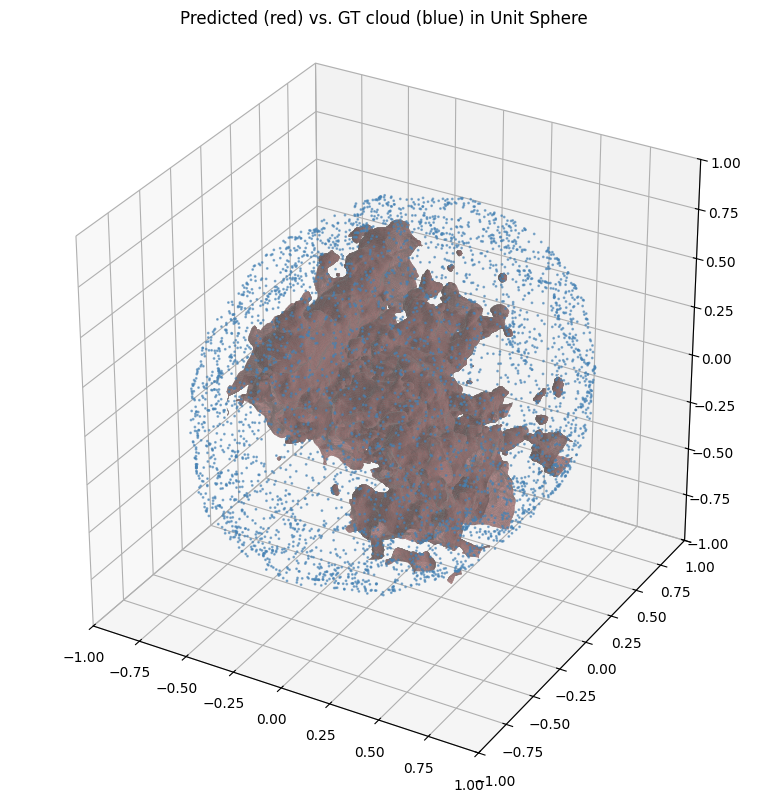

[MAIN] Visualization complete.


In [5]:

    # -------------------------------------------------------------------------
    # 12) Extract & visualize the 3D mesh (normalized + GT overlay)
    # -------------------------------------------------------------------------
    print("\n[MAIN] Extracting 3D mesh via marching cubes…")
    pred_mesh = extract_3d_from_nerf(
        model,
        resolution=256,
        bound=1.0,
        sigma_scale=1.0,
        device=dev
    )
    if pred_mesh is None or len(pred_mesh.faces) == 0:
        print("⚠️ No faces found in the predicted mesh.")
        sys.exit(1)

    # ---- 13) Sample & normalize both pred & GT for Chamfer and plotting ----
    print("[MAIN] Sampling 5k points from predicted mesh…")
    pred_pts = pred_mesh.sample(5000)         # numpy (5000,3)
    gt_pts   = pts.cpu().numpy()              # numpy (N,3)

    # center
    pred_centered = pred_pts - pred_pts.mean(0)
    gt_centered   = gt_pts   - gt_pts.mean(0)

    # scale to unit‐sphere
    pred_scale = np.max(np.linalg.norm(pred_centered, axis=1))
    gt_scale   = np.max(np.linalg.norm(gt_centered,   axis=1))
    pred_norm_pts = pred_centered / pred_scale
    gt_norm_pts   = gt_centered   / gt_scale

    # normalized Chamfer
    cd_norm = chamfer_distance(pred_norm_pts, gt_norm_pts)
    print(f"[MAIN] Normalized Chamfer distance: {cd_norm:.6e}")

    # ---- 14) Plot normalized mesh + GT cloud ----
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

    # normalize the mesh vertices themselves
    verts = pred_mesh.vertices             # (V,3)
    verts_centered = verts - verts.mean(0)
    verts_norm     = verts_centered / pred_scale

    faces = pred_mesh.faces                # (F,3)

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111, projection='3d')

    # predicted surface
    ax.plot_trisurf(
        verts_norm[:,0], verts_norm[:,1], verts_norm[:,2],
        triangles=faces,
        color='lightcoral', edgecolor='gray', linewidth=0.1, alpha=0.9
    )
    # ground‑truth cloud
    ax.scatter(
        gt_norm_pts[:,0], gt_norm_pts[:,1], gt_norm_pts[:,2],
        color='steelblue', s=1, alpha=0.6
    )

    # enforce equal data‐ranges on each axis
    half = 1.0  # since both are in unit‐sphere
    ax.set_xlim(-half, half)
    ax.set_ylim(-half, half)
    ax.set_zlim(-half, half)

    ax.set_box_aspect([1,1,1])
    ax.set_title("Predicted (red) vs. GT cloud (blue) in Unit Sphere")
    plt.tight_layout()
    plt.show()

    print("[MAIN] Visualization complete.")


# Strong Shape Prior


# 7 Findings & Failure analysis


We typically observe **scale drift** (mesh ~2× larger) and missing spikes because two views under‑constrain the density field.  Nevertheless, a coarse ellipsoidal hull is recovered.

# 8 Conclusion & next steps

*Even this bare‑bones NeRF recovers a *hint* of the true shape but fails at fine detail and absolute scale.*  Next experiments will add **geometric priors** (radial profile, symmetry) and **multi‑scale sampling** to address these issues.
